In [1]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:52053 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [2]:
import os
import dask.dataframe as ddf

def transform(line):
    if "geometry" not in line:
        return None
    props = line["properties"]
    geom = line["geometry"]
    return {
        'ts': props["timestamp"],
        'alt': props["altitude"] if 'altitude' in props else None,
        'vacc': props["vertical_accuracy"] if 'vertical_accuracy' in props else None,
        'hacc': props["horizontal_accuracy"] if "horizontal_accuracy" in props else None,
        'wifi': props["wifi"],
        'batt': props["battery_level"] if "battery_level" in props else None,
        'mot': props["motion"] if "motion" in props else None,
        'speed': props["speed"] if "speed" in props else None,
        'lat': geom["coordinates"][1],
        'lon': geom["coordinates"][0],
    }

def load_data():
    import dask.bag as db
    import json
    import pandas as pd
    import datetime
    import numpy as np
    jsons = db.read_text("dl/history/*.json").map(json.loads).map(transform).filter(lambda x: x is not None)
    meta = {
        'ts': str, #todo fix
        'alt': float, #int
        'vacc': float, #int
        'hacc': float, #int
        'wifi': str,
        'batt': float,
        'mot': str,
        'speed': float, #int
        'lat': float,
        'lon': float,
    }
    df = jsons.to_dataframe(meta=meta)
    df["ts"]= ddf.to_datetime(df["ts"]) 
    return df
  
exists = os.path.isfile('output/out.csv')
df = load_data() if not exists else ddf.read_csv('output/out.csv')
df = client.persist(df)
if not exists:
    df.to_csv('output/out.csv', single_file=True, index=False)
df = df.compute()

In [3]:
df.describe()

,alt,vacc,hacc,batt,speed,lat,lon
count,1.420155e+06,1.420155e+06,1.422118e+06,1.422346e+06,1.420155e+06,1.422347e+06,1.422347e+06
mean,2.409502e+02,1.221102e+01,3.447902e+01,6.740761e-01,8.937144e+00,4.226619e+01,-8.326384e+01
std,5.155379e+02,8.888274e+01,3.994186e+02,2.449829e-01,1.552077e+01,7.851339e-01,5.355222e+00
min,-4.500000e+02,-1.000000e+00,1.000000e+00,1.000000e-02,-1.000000e+00,3.887890e+01,-1.223406e+02
25%,2.050000e+02,3.000000e+00,1.200000e+01,4.900000e-01,0.000000e+00,4.227503e+01,-8.367141e+01
50%,2.130000e+02,3.000000e+00,1.600000e+01,7.200000e-01,1.000000e+00,4.228734e+01,-8.350037e+01
75%,2.500000e+02,8.000000e+00,3.200000e+01,8.900000e-01,1.800000e+01,4.232261e+01,-8.343214e+01
max,1.110800e+04,3.163300e+04,1.490000e+05,1.000000e+00,2.750000e+02,4.766141e+01,-7.070574e+01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c269588>,
      dtype=object)

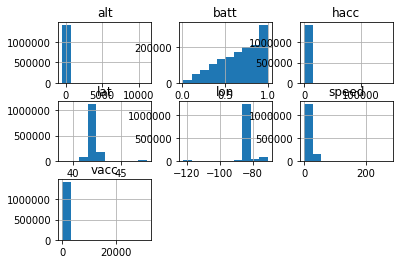

In [4]:
df.hist()

In [5]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat)) 

In [6]:
locations = gpd.read_file('map.geojson')
locations

,name,geometry
0,Sweeting,"POLYGON ((-83.73374 42.27497, -83.73373 42.275..."
1,Ann Arbor,"POLYGON ((-83.71016 42.25927, -83.68887 42.255..."
2,Home (oakham),"POLYGON ((-83.49924 42.28679, -83.49928 42.287..."
3,WL,"POLYGON ((-83.13054 42.61761, -83.12770 42.617..."
4,Coco,"POLYGON ((-83.72102 42.29907, -83.72227 42.299..."
5,No-thai (north campus),"POLYGON ((-83.72151 42.29864, -83.72150 42.298..."
6,No-thai (central campus),"POLYGON ((-83.73304 42.27422, -83.73247 42.274..."
7,Cha-time,"POLYGON ((-83.74207 42.27786, -83.74203 42.278..."


In [7]:
%%time
subset = gdf[gdf['ts'] >= '2020-01-01']
subset_in_interest = gpd.sjoin(subset, locations, how='inner', op='within')

/Users/ncrocker/dev/personal/overland-lambda/rollup/venv/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


CPU times: user 6.85 s, sys: 275 ms, total: 7.12 s
Wall time: 8.33 s


In [8]:
from keplergl import KeplerGl
%run map_config.py
map_1 = KeplerGl(height=600, width=600, config=config)
map_1.add_data(subset, name='track')
map_1.add_data(locations, name='locations')
map_1.add_data(subset_in_interest, name='interest')

map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': 'track', 'id': '0hcxkgoh', 'n…

In [9]:
with open('map_config.py', 'w') as f:
   f.write('config = {}'.format(map_1.config))